## Importing dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import calendar

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))

## Reading data

In [2]:
# Read the dataset
data_dir = '/kaggle/input/competitive-data-science-predict-future-sales/'
sales        = pd.read_csv(data_dir + 'sales_train.csv')
items        = pd.read_csv(data_dir + 'items.csv') 
categories   = pd.read_csv(data_dir + 'item_categories.csv')
shops        = pd.read_csv(data_dir + 'shops.csv')
test         = pd.read_csv(data_dir + 'test.csv')
submit_sample= pd.read_csv(data_dir + 'sample_submission.csv')

In [3]:
#Data Downcasting
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [sales, shops, items, categories, test]
for df in all_df:
    df = downcast(df)

62.5% compressed
38.6% compressed
54.2% compressed
39.9% compressed
70.8% compressed


First of all, let's take a look at the all data files we have

In [4]:
# Generate descriptive statistics for the data in the DataFrame
sales.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,2935849,1034,28.12.2013,9434,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_block_num,2935849.0,NaN,NaN,NaN,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,NaN,NaN,NaN,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,NaN,NaN,NaN,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,NaN,NaN,NaN,890.623413,1726.439819,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,NaN,NaN,NaN,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int8   
 2   shop_id         int8   
 3   item_id         int16  
 4   item_price      float32
 5   item_cnt_day    int16  
dtypes: float32(1), int16(2), int8(2), object(1)
memory usage: 50.4+ MB


In [6]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1
1,03.01.2013,0,25,2552,899.000000,1
2,05.01.2013,0,25,2552,899.000000,-1
3,06.01.2013,0,25,2554,1709.050049,1
4,15.01.2013,0,25,2555,1099.000000,1


In [7]:
items.describe(include='all')

,item_name,item_id,item_category_id
count,22170,22170.00000,22170.000000
unique,22170,NaN,NaN
top,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,NaN,NaN
freq,1,NaN,NaN
mean,NaN,11084.50000,46.290753
std,NaN,6400.07207,15.941486
min,NaN,0.00000,0.000000
25%,NaN,5542.25000,37.000000
50%,NaN,11084.50000,40.000000
75%,NaN,16626.75000,58.000000


In [8]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [10]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


# EDA

In this section we will go thorugh a journey to descover the data we have

In [11]:
# descover the number of items in each category
items_per_cat = items.groupby(['item_category_id']).agg({'item_id':'sum'})
items_per_cat = items_per_cat.sort_values(by='item_id', ascending=False)
items_per_cat = items_per_cat.reset_index()
items_per_cat.head()

,item_category_id,item_id
0,40,72210206.0
1,37,25727760.0
2,55,22265404.0
3,72,13323178.0
4,61,11617191.0


Text(0.5, 1.0, 'Items in each category')

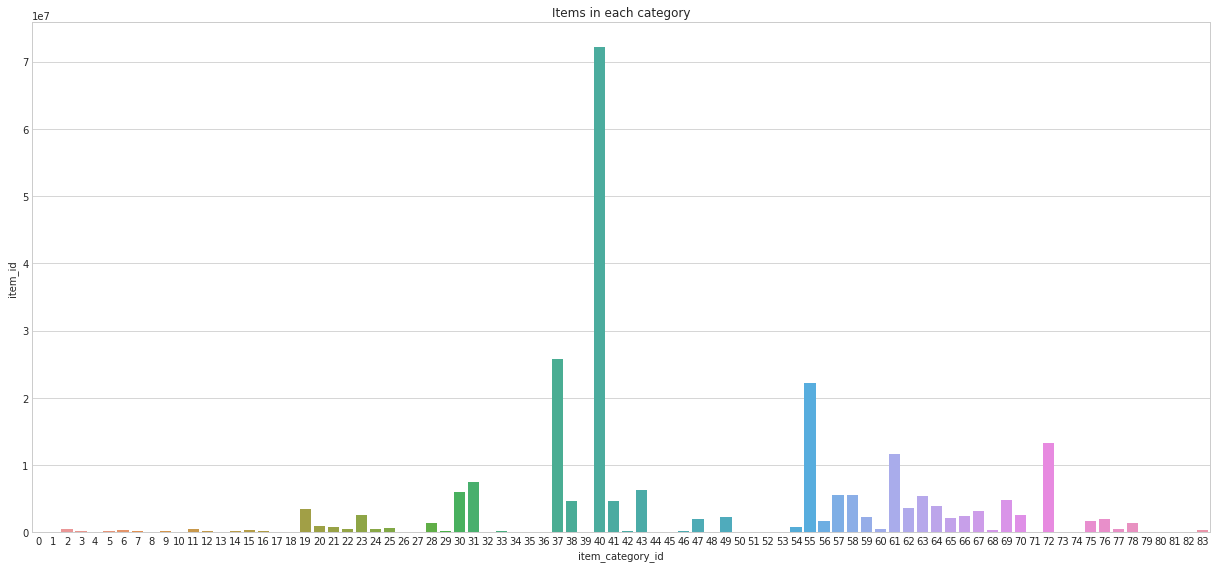

In [12]:
plt.figure(figsize=(17,8))
sns.barplot(x='item_category_id', y='item_id', data=items_per_cat).set_title('Items in each category')

In [13]:
# no. of items sold from each shop
items_per_shop = sales.groupby(['shop_id']).sum()
items_per_shop = items_per_shop.reset_index()
items_per_shop = items_per_shop.sort_values(by='item_cnt_day', ascending=False)
items_per_shop[['shop_id', 'item_cnt_day']].head()

,shop_id,item_cnt_day
31,31,310777.0
25,25,241920.0
54,54,185790.0
28,28,184557.0
42,42,144934.0


Text(0.5, 1.0, 'Items sold in each shop')

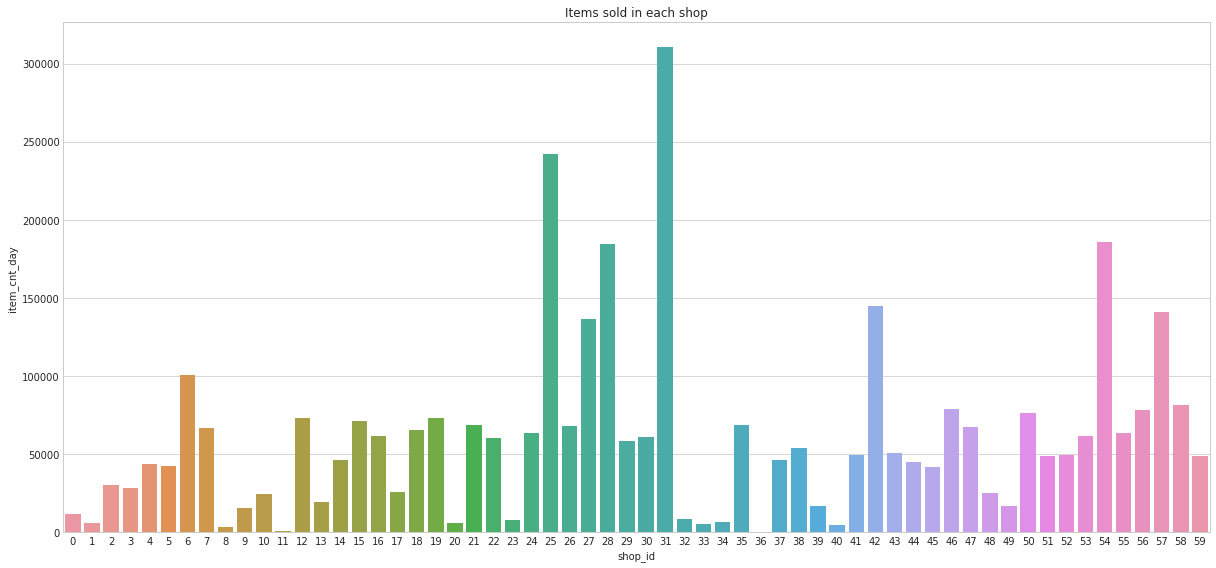

In [14]:
plt.figure(figsize=(17,8))
sns.barplot(x='shop_id', y='item_cnt_day', data=items_per_shop).set_title('Items sold in each shop')

In [15]:
# the amount of sales within each price range
sales_with_price = sales.sort_values('item_price')
sales_with_price = sales_with_price.groupby(pd.cut(sales_with_price['item_price'], 
                                            np.arange(sales_with_price['item_price'].min(), 
                                            sales_with_price['item_price'].max(), 
                                            sales_with_price['item_price'].max()/200))).agg({'item_cnt_day':'sum'})

sales_with_price = sales_with_price.rename({'item_price': 'price'}, axis=1)
sales_with_price = sales_with_price.iloc[0:20].reset_index()
sales_with_price = sales_with_price.rename({'item_price': 'price_range'}, axis=1)

sales_with_price = sales_with_price.reset_index()
sales_with_price

,index,price_range,item_cnt_day
0,0,"(-1.0, 1538.9]",3089859.0
1,1,"(1538.9, 3078.8]",433357.0
2,2,"(3078.8, 4618.7]",76458.0
3,3,"(4618.7, 6158.6]",10799.0
4,4,"(6158.6, 7698.5]",2965.0
5,5,"(7698.5, 9238.4]",4578.0
6,6,"(9238.4, 10778.3]",4584.0
7,7,"(10778.3, 12318.2]",1809.0
8,8,"(12318.2, 13858.1]",3275.0
9,9,"(13858.1, 15398.0]",4377.0


Text(0.5, 1.0, 'Sales for each price range')

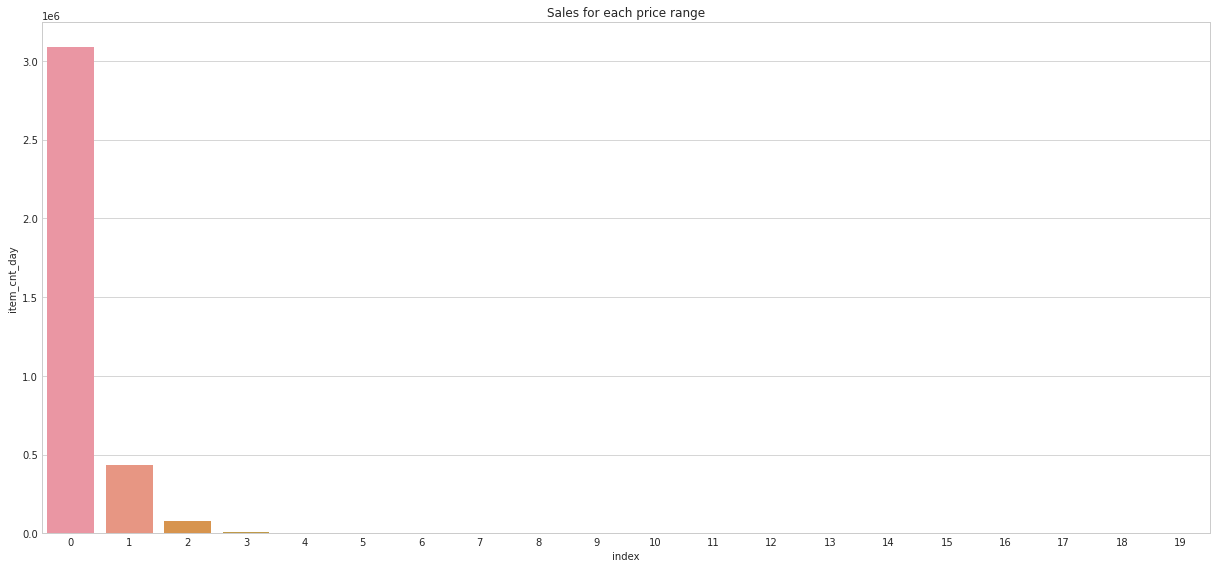

In [16]:
plt.figure(figsize=(17,8))
sns.barplot(x='index', y='item_cnt_day', data=sales_with_price).set_title('Sales for each price range')

We will plot all price ranges again but without the first two to make the graph more abvious.

Text(0.5, 1.0, 'Sales for each price range')

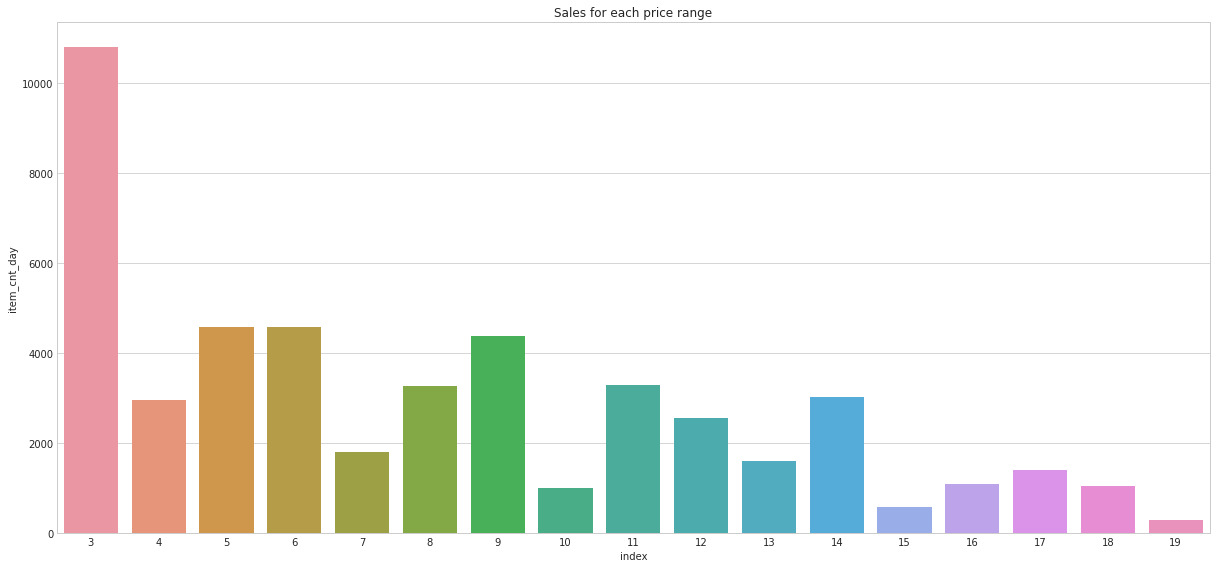

In [17]:
plt.figure(figsize=(17,8))
sns.barplot(x='index', y='item_cnt_day', data=sales_with_price[3:]).set_title('Sales for each price range')

In [18]:
#finding the number of items sold in each month
items_per_month = sales.groupby(['date_block_num']).agg({'item_cnt_day':'sum'})
items_per_month = items_per_month.reset_index()
items_per_month.head()

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0


Text(0.5, 1.0, '#Items sold in each month')

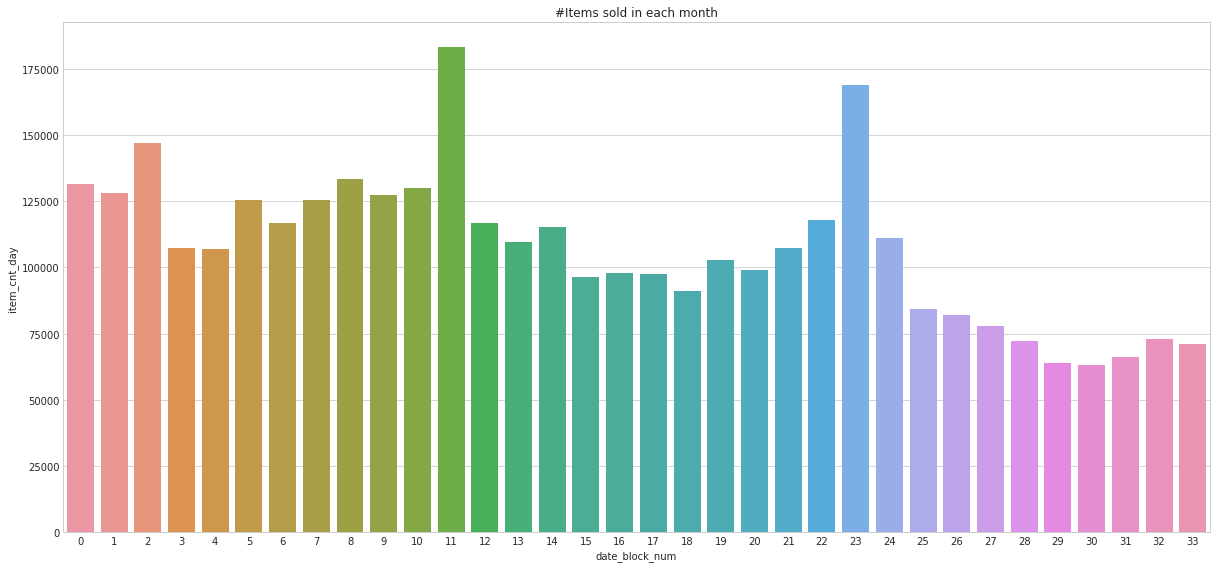

In [19]:
plt.figure(figsize=(17,8))
sns.barplot(x='date_block_num', y='item_cnt_day', data=items_per_month).set_title('#Items sold in each month')

Text(0.5, 1.0, '#Items sold in each month')

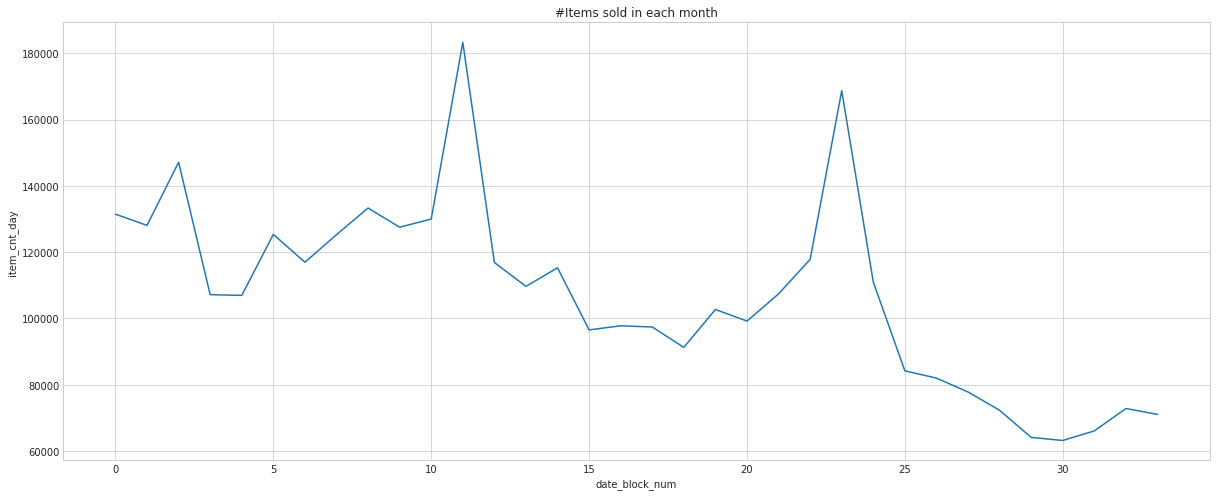

In [20]:
plt.figure(figsize=(17,7))
sns.lineplot(x='date_block_num', y='item_cnt_day', data=items_per_month).set_title('#Items sold in each month')

Now let's combine all data files for further exploring

In [21]:
# Join data files
all_data = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
all_data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,02.01.2013,0,59,22154,999.000000,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.000000,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,05.01.2013,0,25,2552,899.000000,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,06.01.2013,0,25,2554,1709.050049,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,15.01.2013,0,25,2555,1099.000000,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства
...,...,...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.000000,1,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935845,09.10.2015,33,25,7460,299.000000,1,V/A The Golden Jazz Collection 1 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935846,14.10.2015,33,25,7459,349.000000,1,V/A The Best Of The 3 Tenors,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935847,22.10.2015,33,25,7440,299.000000,1,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,"Москва ТРК ""Атриум""",Музыка - MP3


In [22]:
all_data['revenue'] = all_data['item_cnt_day'] * all_data['item_price']
all_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,revenue
0,02.01.2013,0,59,22154,999.000000,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,999.000000
1,03.01.2013,0,25,2552,899.000000,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,899.000000
2,05.01.2013,0,25,2552,899.000000,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,-899.000000
3,06.01.2013,0,25,2554,1709.050049,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,1709.050049
4,15.01.2013,0,25,2555,1099.000000,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,1099.000000


In [23]:
monthly_revenue = all_data.groupby(['date_block_num'], as_index=False).agg({'revenue':'sum'})
monthly_revenue.head()

,date_block_num,revenue
0,0,91947088.0
1,1,90665704.0
2,2,104932688.0
3,3,69154288.0
4,4,65065312.0


Text(0.5, 1.0, 'Monthly Revenue')

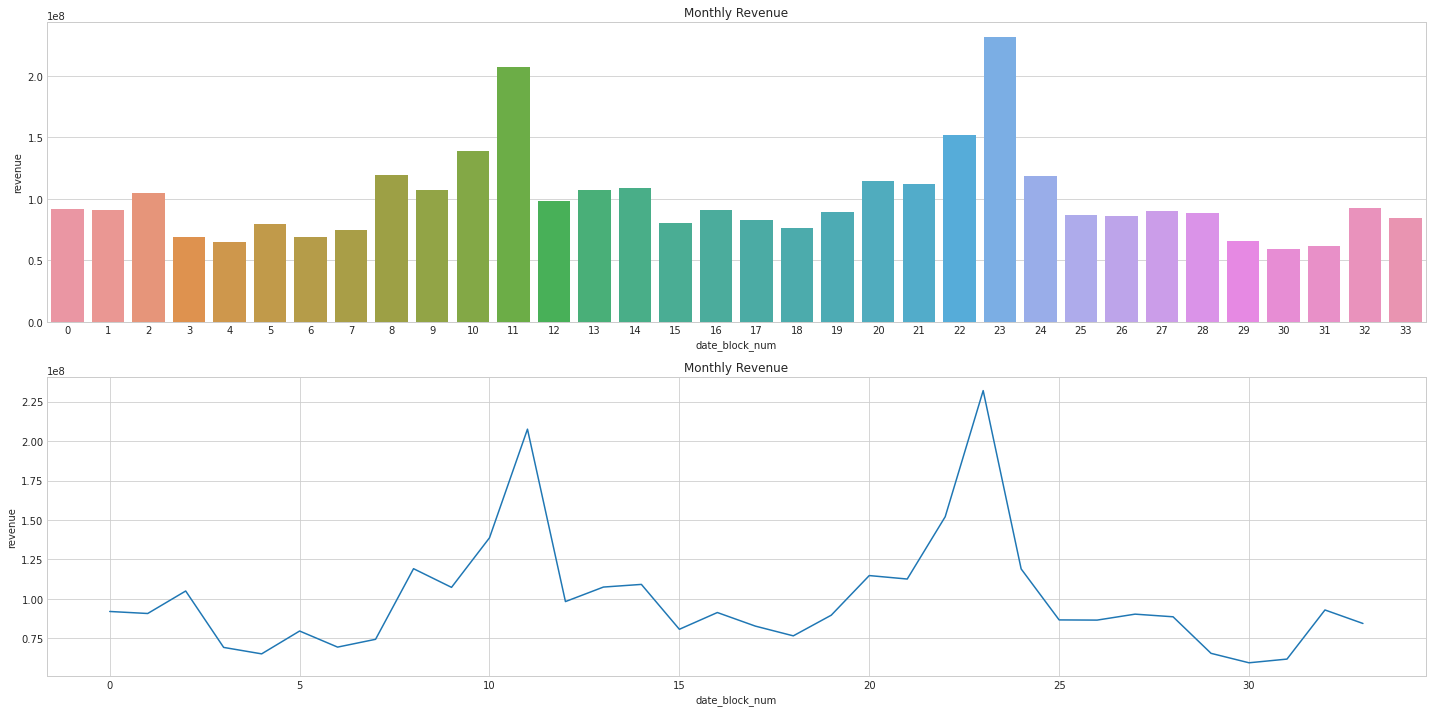

In [24]:
f, axes = plt.subplots(2, 1, figsize=(20,10))
sns.barplot(x='date_block_num', y='revenue', data=monthly_revenue, ax=axes[0]).set_title('Monthly Revenue')                                   
sns.lineplot(x='date_block_num', y='revenue', data=monthly_revenue, ax=axes[1]).set_title('Monthly Revenue')

In [25]:
# change time format to do comparison 
all_data['year'] = all_data['date_block_num'].apply(lambda x: ((x//12) + 2013))
all_data['month'] = all_data['date_block_num'].apply(lambda x: (x %12) +1 )
all_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,revenue,year,month
0,02.01.2013,0,59,22154,999.000000,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,999.000000,2013,1
1,03.01.2013,0,25,2552,899.000000,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,899.000000,2013,1
2,05.01.2013,0,25,2552,899.000000,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,-899.000000,2013,1
3,06.01.2013,0,25,2554,1709.050049,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,1709.050049,2013,1
4,15.01.2013,0,25,2555,1099.000000,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,1099.000000,2013,1


In [26]:
#To convert month int to month name
all_data['month'] = all_data['month'].apply(lambda x: calendar.month_abbr[x])

In [27]:
data = all_data[['month', 'year', 'item_cnt_day']]
data = data.sort_values(['month'])
data

,month,year,item_cnt_day
411271,Apr,2013,1
416186,Apr,2013,1
416187,Apr,2013,1
416188,Apr,2013,1
416189,Apr,2013,1
...,...,...,...
860080,Sep,2013,1
860079,Sep,2013,1
860078,Sep,2013,1
860076,Sep,2013,1


In [28]:
monthly_sales_each_year = data.pivot_table(index='month', columns='year', values='item_cnt_day', aggfunc="sum")
monthly_sales_each_year

year,2013,2014,2015
month,,,
Apr,107190.0,96556.0,77827.0
Aug,125291.0,102721.0,66079.0
Dec,183342.0,168755.0,NaN
Feb,128090.0,109687.0,84198.0
Jan,131479.0,116899.0,110971.0
Jul,116966.0,91280.0,63187.0
Jun,125381.0,97429.0,64114.0
Mar,147142.0,115297.0,82014.0
May,106970.0,97790.0,72295.0


In [29]:
revenue_data = all_data[['month', 'year', 'revenue']]
monthly_average_revenue_each_year = revenue_data.pivot_table(index='month', columns='year', values='revenue')
monthly_average_revenue_each_year

year,2013,2014,2015
month,,,
Apr,734.831787,1035.244507,1603.810181
Aug,709.139526,1034.522095,1082.764282
Dec,1449.057739,1774.082642,NaN
Feb,834.759277,1195.938110,1205.908569
Jan,794.771301,988.696655,1343.481812
Jul,689.726318,971.151855,1069.430420
Jun,792.311035,1003.161560,1197.392700
Mar,864.732422,1176.662109,1235.781250
May,709.089172,1162.395264,1623.843872


Text(0.5, 1.0, 'Monthly revenue')

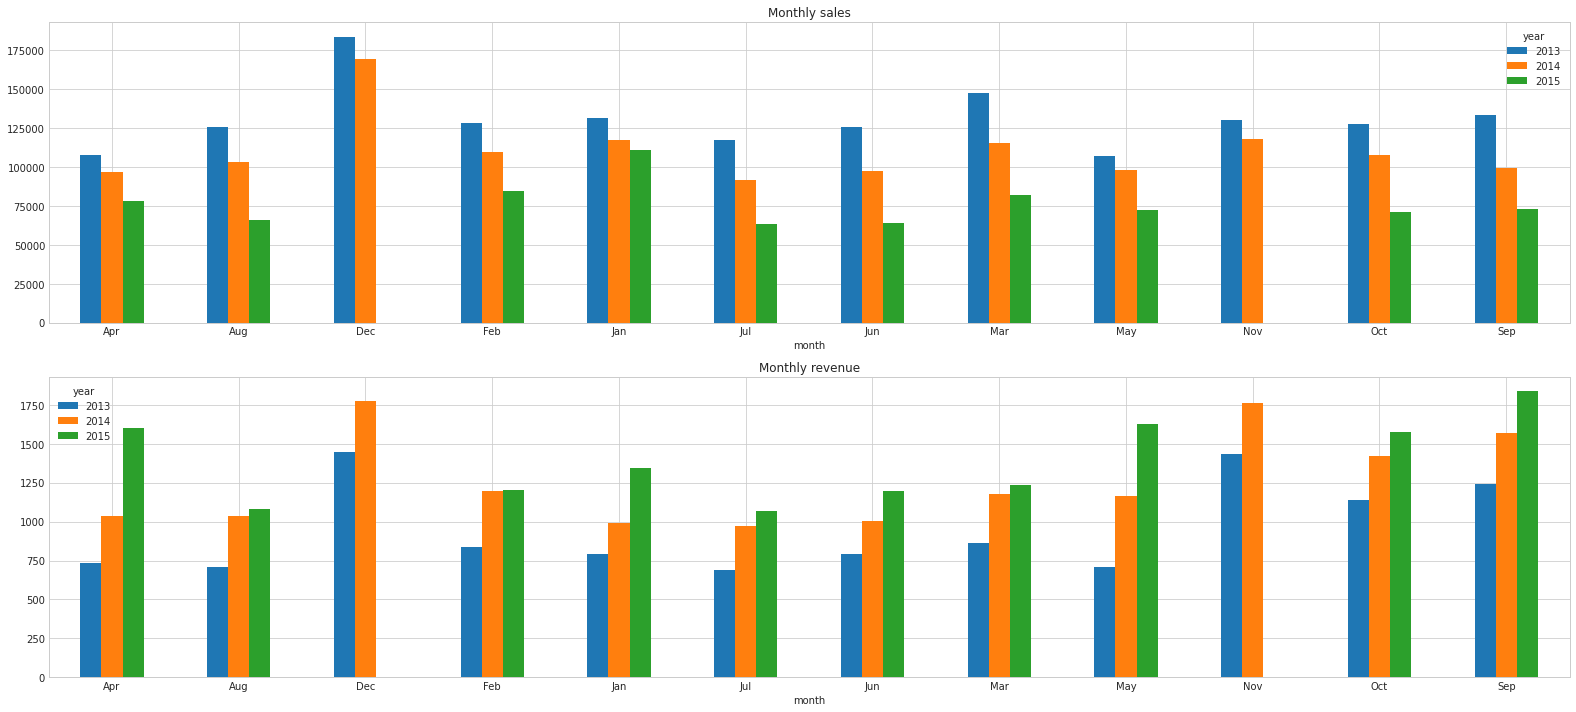

In [30]:
f, axes = plt.subplots(2, 1, figsize=(22,10))
monthly_sales_each_year.plot(kind='bar', rot=0, ax=axes[0]).set_title('Monthly sales')                                       
monthly_average_revenue_each_year.plot(kind='bar', rot=0, ax=axes[1]).set_title('Monthly revenue') 

Let's figure out the distribution of items' price

<AxesSubplot:xlabel='item_price'>

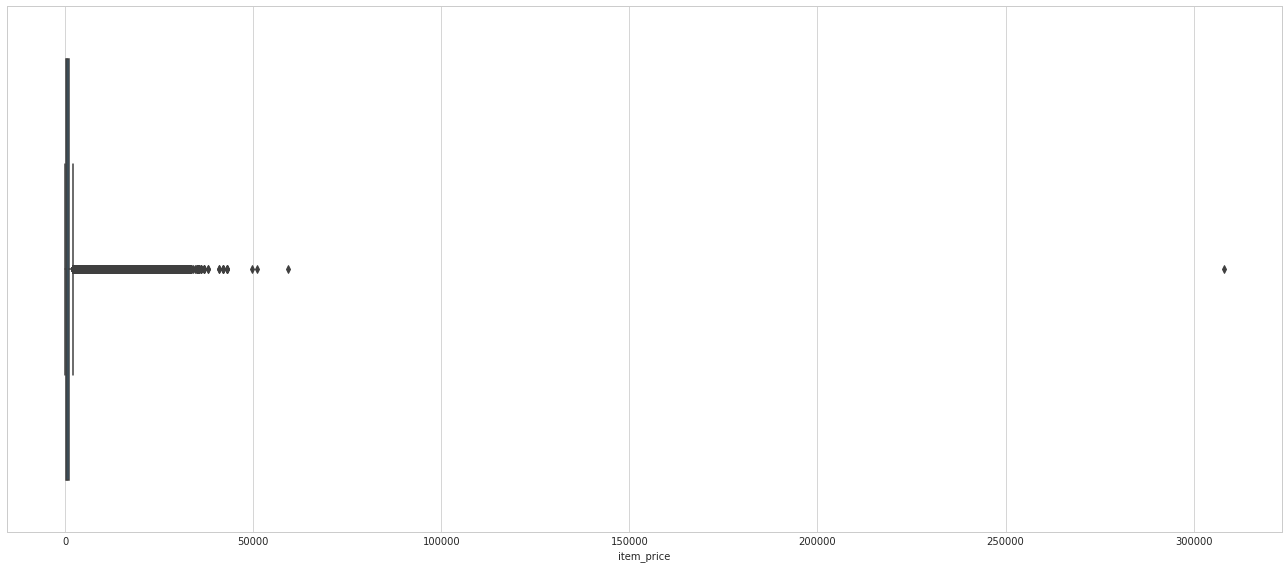

In [31]:
plt.figure(figsize=(18,8))
sns.boxplot(x=sales['item_price'])

For better visualization, we will remove the outliers 

<AxesSubplot:xlabel='item_price'>

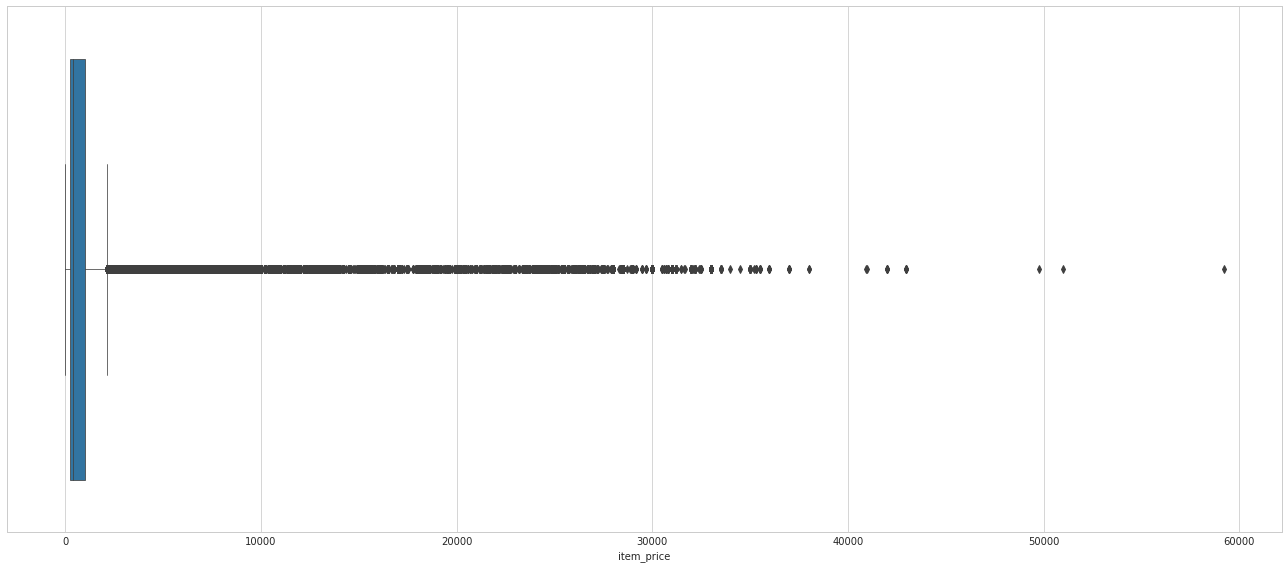

In [32]:
sales_ = sales[(sales.item_price < 100000)]

plt.figure(figsize=(18,8))
sns.boxplot(x=sales_['item_price'], linewidth=.75)

In [33]:
# Leaking to imporve performance
unique_train_shop_id = sales['shop_id'].unique()
unique_test_shop_id = test['shop_id'].unique()
print('the unique shop_ids in train data are:', unique_train_shop_id)
print('-'*100)
print('the unique shop_ids in test data are:', unique_test_shop_id)

the unique shop_ids in train data are: [59 25 24 23 19 22 18 21 28 27 29 26  4  6  2  3  7  0  1 16 15  8 10 14
 13 12 53 31 30 32 35 56 54 47 50 42 43 52 51 41 38 44 37 46 45  5 57 58
 55 17  9 49 39 40 48 34 33 20 11 36]
----------------------------------------------------------------------------------------------------
the unique shop_ids in test data are: [ 5  4  6  3  2  7 10 12 28 31 26 25 22 24 21 15 16 18 14 19 42 50 49 53
 52 47 48 57 58 59 55 56 36 37 35 38 34 46 41 44 39 45]


By searching, I found out that the first word in the name of shop_names is the city in which the corresponding shop_id locates.

In [34]:
all_data['city'] = all_data['shop_name'].apply(lambda x: x.split()[0])

In [35]:
all_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,revenue,year,month,city
0,02.01.2013,0,59,22154,999.000000,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,999.000000,2013,Jan,Ярославль
1,03.01.2013,0,25,2552,899.000000,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,899.000000,2013,Jan,Москва
2,05.01.2013,0,25,2552,899.000000,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,-899.000000,2013,Jan,Москва
3,06.01.2013,0,25,2554,1709.050049,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,1709.050049,2013,Jan,Москва
4,15.01.2013,0,25,2555,1099.000000,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,1099.000000,2013,Jan,Москва


In [36]:
all_data['city'].unique()

array(['Ярославль', 'Москва', 'Курск', 'Красноярск', 'Волжский',
       'Воронеж', 'Адыгея', 'Балашиха', '!Якутск', 'Коломна', 'Калуга',
       'Жуковский', 'Казань', 'Интернет-магазин', 'Уфа', 'Н.Новгород',
       'Чехов', 'Химки', 'Сургут', 'Тюмень', 'СПб', 'РостовНаДону',
       'Омск', 'Самара', 'Новосибирск', 'Сергиев', 'Вологда', 'Якутск',
       'Цифровой', 'Выездная', 'Томск', 'Мытищи'], dtype=object)

In [37]:
all_data.loc[all_data['city'] =='!Якутск', 'city'] = 'Якутск'

In [38]:
all_data.city.unique()

array(['Ярославль', 'Москва', 'Курск', 'Красноярск', 'Волжский',
       'Воронеж', 'Адыгея', 'Балашиха', 'Якутск', 'Коломна', 'Калуга',
       'Жуковский', 'Казань', 'Интернет-магазин', 'Уфа', 'Н.Новгород',
       'Чехов', 'Химки', 'Сургут', 'Тюмень', 'СПб', 'РостовНаДону',
       'Омск', 'Самара', 'Новосибирск', 'Сергиев', 'Вологда', 'Цифровой',
       'Выездная', 'Томск', 'Мытищи'], dtype=object)

How many items were sold by each shop in a month?

In [39]:
monthly_items_each_shop = all_data.groupby(['month','city']).agg({'item_cnt_day':'sum'}).reset_index()
monthly_items_each_shop

,month,city,item_cnt_day
0,Apr,Адыгея,2233.0
1,Apr,Балашиха,2072.0
2,Apr,Волжский,2339.0
3,Apr,Вологда,3117.0
4,Apr,Воронеж,12782.0
...,...,...,...
354,Sep,Химки,12861.0
355,Sep,Цифровой,9928.0
356,Sep,Чехов,5902.0
357,Sep,Якутск,17448.0


In [40]:
#the city of the largest sales
monthly_items_each_shop.item_cnt_day
monthly_items_each_shop[monthly_items_each_shop.item_cnt_day==monthly_items_each_shop.item_cnt_day.max()]

,month,city,item_cnt_day
133,Jan,Москва,126883.0


Text(0.5, 1.0, '#Items sold monthly in each shop')

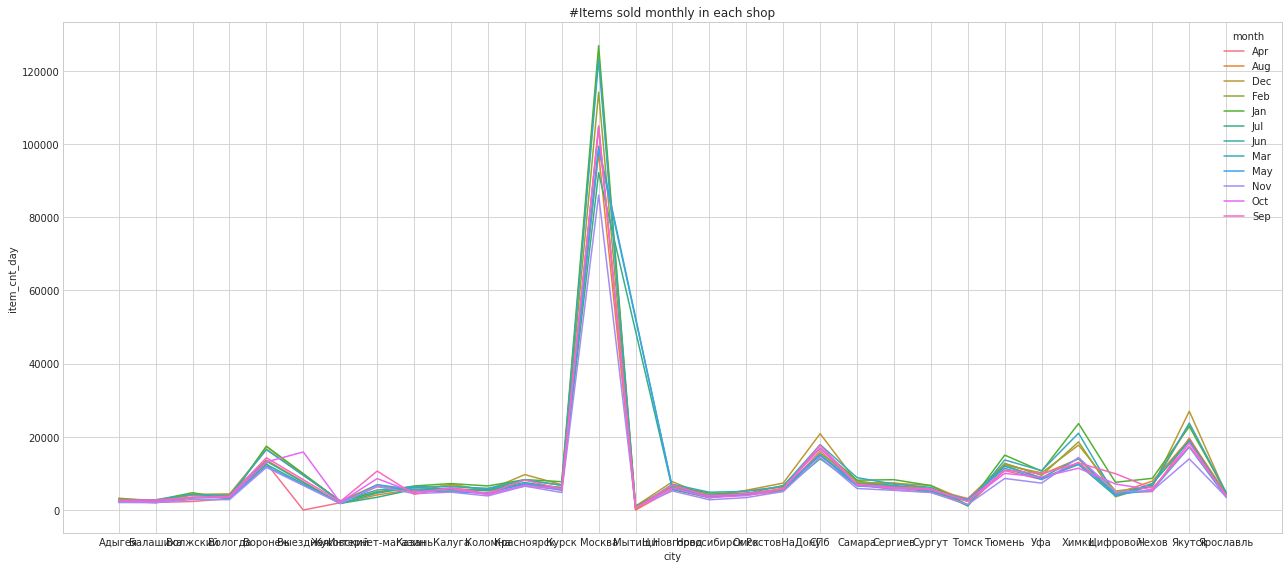

In [41]:
plt.figure(figsize=(18,8))
sns.lineplot(data=monthly_items_each_shop, x='city', y='item_cnt_day', hue='month').set_title('#Items sold monthly in each shop')  

In [42]:
monthly_items_each_shop = monthly_items_each_shop.pivot(index='month', columns='city', values='item_cnt_day').fillna(0)

In [43]:
monthly_items_each_shop

city,Адыгея,Балашиха,Волжский,Вологда,Воронеж,Выездная,Жуковский,Интернет-магазин,Казань,Калуга,...,Сергиев,Сургут,Томск,Тюмень,Уфа,Химки,Цифровой,Чехов,Якутск,Ярославль
month,,,,,,,,,,,,,,,,,,,,,
Apr,2233.0,2072.0,2339.0,3117.0,12782.0,-1.0,1996.0,6346.0,5192.0,5203.0,...,5523.0,4870.0,1422.0,10774.0,8325.0,13033.0,4693.0,5045.0,19690.0,3670.0
Aug,2773.0,2458.0,4047.0,4340.0,13647.0,0.0,1843.0,4121.0,5669.0,5905.0,...,7417.0,5722.0,3146.0,12630.0,9705.0,13982.0,4426.0,7927.0,19339.0,4506.0
Dec,3243.0,2409.0,4319.0,4350.0,16631.0,0.0,2402.0,6896.0,5042.0,7022.0,...,7320.0,6716.0,2425.0,12264.0,10166.0,17732.0,5182.0,6400.0,27002.0,4329.0
Feb,2306.0,2409.0,4304.0,3230.0,17338.0,0.0,2435.0,5010.0,6130.0,6627.0,...,6654.0,5872.0,1103.0,12759.0,9491.0,18621.0,3618.0,6693.0,23380.0,4523.0
Jan,3023.0,2712.0,4732.0,3043.0,17429.0,0.0,2347.0,4777.0,6580.0,7230.0,...,8290.0,6678.0,1413.0,15006.0,10630.0,23627.0,7579.0,8665.0,22832.0,4801.0
Jul,2430.0,2014.0,3311.0,3660.0,12468.0,0.0,1809.0,3489.0,5652.0,5565.0,...,6494.0,4836.0,2593.0,12001.0,8770.0,12413.0,3836.0,7146.0,19033.0,3821.0
Jun,2593.0,2284.0,3470.0,3673.0,13339.0,0.0,1780.0,4619.0,6259.0,5522.0,...,6710.0,5182.0,2381.0,12040.0,8827.0,14134.0,3992.0,7254.0,18830.0,3777.0
Mar,2505.0,2805.0,4284.0,3935.0,16504.0,0.0,2485.0,5470.0,6383.0,6363.0,...,7078.0,6202.0,1171.0,13690.0,10759.0,20989.0,3873.0,6772.0,23769.0,4694.0
May,2306.0,2217.0,3428.0,3328.0,11929.0,0.0,1851.0,6906.0,5625.0,4912.0,...,5936.0,5468.0,2883.0,11406.0,8418.0,12599.0,4192.0,5446.0,17219.0,3474.0


<AxesSubplot:xlabel='city', ylabel='month'>

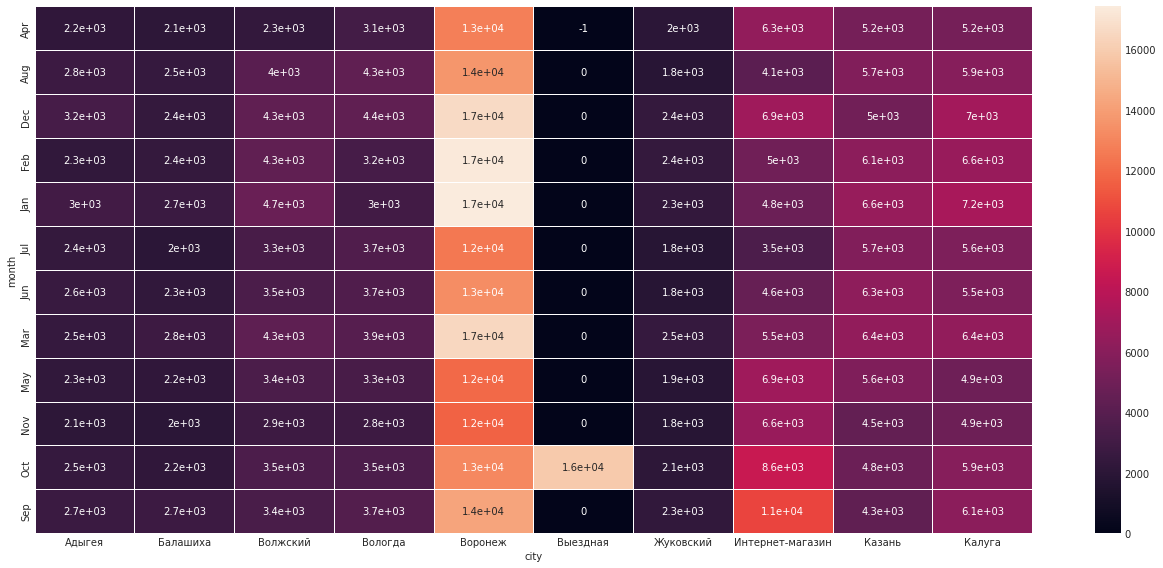

In [44]:
plt.figure(figsize=(18,8))
sns.heatmap(monthly_items_each_shop.iloc[:,:10], annot=True, linewidth=.5)